In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

import shap
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

c:\Users\lamor\anaconda3\envs\old_health\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
temp = pd.read_csv('data/population_sample.csv')
region_code_dict = {int(x.split(' ')[0]):x.split(' ')[1] for x in np.unique(temp['A 행정구역(시군구)별'])}
region_code_dict[27] = 'Nan'

In [3]:
scores = []
for i in range(2, 10):
    temp = pd.read_csv('data/refined/score_%s.csv' % i)
    temp['year'] = i
    temp.columns = [col[3:] if col[:2]=='w0' else col for col in temp.columns]
    scores.append(temp)
scores = pd.concat(scores)

# Check whether there is nan value
nan_columns = scores.isna().sum()
nan_columns_with_values = nan_columns[nan_columns > 0]
nan_columns_with_values

Series([], dtype: int64)

In [4]:
x_data = scores[[col for col in scores.columns if col[:5]!='score']]
y_data = scores['score']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=True)

### Factor Analysis

#### Linear Regressor

In [5]:
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

LinearRegression()

In [6]:
print("Model coefficients:\n")
linear_coeff = {}
for i in range(x_train.shape[1]):
    linear_coeff[x_train.columns[i]] = linear_regressor.coef_[i].round(5)
linear_coeff = pd.DataFrame.from_dict(data=linear_coeff, orient='index', columns=['coefficient'])
linear_coeff['abs'] = linear_coeff['coefficient'].abs()
linear_coeff.sort_values(by='abs', inplace=True, ascending=False)
linear_coeff

Model coefficients:



,coefficient,abs
G026,0.10000,0.10000
G027,0.10000,0.10000
G028,0.10000,0.10000
G029,0.10000,0.10000
G030,0.10000,0.10000
hhinc,0.06250,0.06250
hhassets,0.06250,0.06250
G041,0.02500,0.02500
G039,0.02500,0.02500
G037,0.02500,0.02500


In [7]:
linear_explainer = shap.LinearExplainer(linear_regressor, x_train)
linear_shap_values = linear_explainer.shap_values(x_train)
pd.DataFrame(linear_shap_values, columns=x_train.columns).to_csv('shap_value_linear.csv')

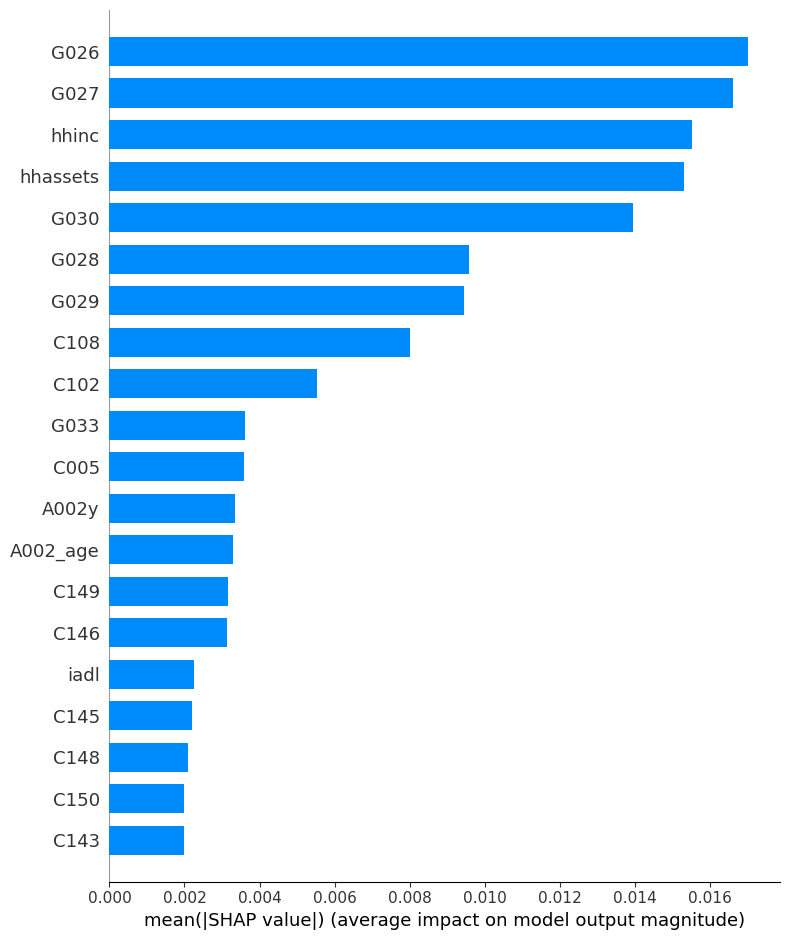

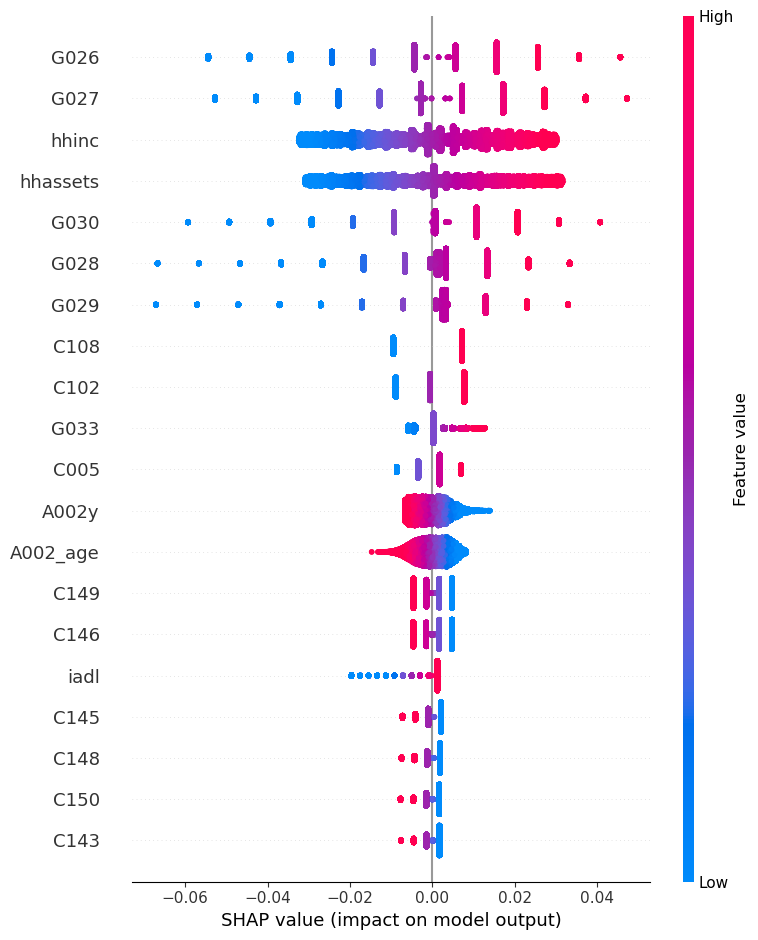

In [8]:
shap.summary_plot(linear_shap_values, x_train, feature_names=x_train.columns, plot_type="bar")
shap.summary_plot(linear_shap_values, x_train, feature_names=x_train.columns)

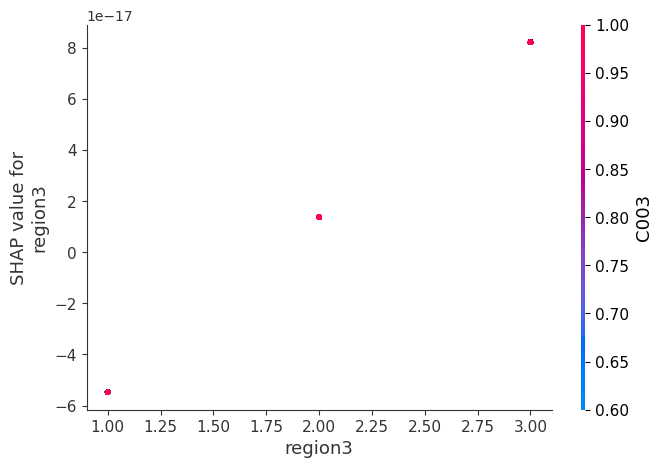

In [9]:
shap.dependence_plot(5, linear_shap_values, x_train, feature_names=x_train.columns)
# shap.decision_plot(linear_explainer.expected_value[0], linear_shap_values[0], feature_names = list(x_train.columns))


#### Random Forest Regressor

In [8]:
rfr_regressor = RandomForestRegressor()
rfr_regressor.fit(x_train, y_train)

RandomForestRegressor()

In [9]:
# Get feature importances from the RandomForestRegressor
feature_importances = rfr_regressor.feature_importances_

# Set a threshold (e.g., keep features that contribute at least 1%)
threshold = 0.01
important_features_rfr = [i for i, imp in enumerate(feature_importances) if imp > threshold]

# Filter the training data to include only important features
x_train_filtered_rfr = x_train.iloc[:, important_features_rfr]
x_test_filtered_rfr = x_test.iloc[:, important_features_rfr]

In [10]:
important_features_rfr

[8, 9, 10, 11, 12, 29, 30]

In [11]:
# train model again with filtered features
rfr_regressor = RandomForestRegressor()
rfr_regressor.fit(x_train_filtered_rfr, y_train)

RandomForestRegressor()

In [14]:
rfr_explainer = shap.TreeExplainer(rfr_regressor)

rfr_shap_values = np.zeros_like(x_train_filtered_rfr)
batch_size = 100  # Set batch size according to your data size
for i in tqdm(range(0, x_train_filtered_rfr.shape[0], batch_size)):  # 
    end_idx = min(i + batch_size, x_train_filtered_rfr.shape[0])
    rfr_shap_values[i:end_idx] = rfr_explainer.shap_values(x_train_filtered_rfr[i:end_idx], check_additivity=False)


100%|██████████| 703/703 [12:20:48<00:00, 63.23s/it]  


In [24]:
pd.DataFrame(rfr_shap_values, columns=x_train_filtered_rfr.columns).to_csv('shap_value_rfr.csv')

In [35]:
shap_test = pd.read_csv('shap_value_rfr.csv', index_col=0)
shap_test

,G026,G027,G028,G029,G030,hhassets,hhinc
0,0.016980,0.021020,-0.009029,-0.007077,-0.039595,0.018348,0.029631
1,-0.013576,-0.002470,-0.010120,-0.010310,0.016735,0.007359,0.036552
2,0.051010,-0.010560,-0.005143,0.020664,-0.044933,-0.020419,0.034098
3,0.033606,0.018854,-0.007119,0.007186,0.039299,0.009689,0.032884
4,0.022368,0.018901,0.010408,-0.007803,0.017888,0.011998,0.020652
...,...,...,...,...,...,...,...
70260,0.000574,0.004760,-0.001054,0.003991,0.016310,0.019712,0.033147
70261,-0.008138,0.003292,-0.034860,-0.006845,0.014309,-0.007843,0.027175
70262,-0.083403,-0.004249,0.027473,0.001578,0.053987,0.019008,0.032358
70263,-0.003556,0.001896,-0.013931,-0.003240,0.012575,-0.000571,0.014309


In [29]:
rfr_shap_values

array([[ 0.01698004,  0.02102023, -0.00902903, ..., -0.03959471,
         0.0183483 ,  0.02963129],
       [-0.01357598, -0.0024697 , -0.01012013, ...,  0.01673518,
         0.00735864,  0.03655233],
       [ 0.05100993, -0.01056034, -0.00514308, ..., -0.04493267,
        -0.02041904,  0.03409837],
       ...,
       [-0.08340277, -0.00424928,  0.02747259, ...,  0.0539867 ,
         0.01900788,  0.03235813],
       [-0.00355588,  0.00189635, -0.01393137, ...,  0.01257484,
        -0.00057143,  0.01430945],
       [ 0.02310387, -0.00385949,  0.00034542, ...,  0.02368814,
        -0.0002367 , -0.01542482]])

In [34]:
shap_test

,Unnamed: 0,G026,G027,G028,G029,G030,hhassets,hhinc
0,0,0.016980,0.021020,-0.009029,-0.007077,-0.039595,0.018348,0.029631
1,1,-0.013576,-0.002470,-0.010120,-0.010310,0.016735,0.007359,0.036552
2,2,0.051010,-0.010560,-0.005143,0.020664,-0.044933,-0.020419,0.034098
3,3,0.033606,0.018854,-0.007119,0.007186,0.039299,0.009689,0.032884
4,4,0.022368,0.018901,0.010408,-0.007803,0.017888,0.011998,0.020652
...,...,...,...,...,...,...,...,...
70260,70260,0.000574,0.004760,-0.001054,0.003991,0.016310,0.019712,0.033147
70261,70261,-0.008138,0.003292,-0.034860,-0.006845,0.014309,-0.007843,0.027175
70262,70262,-0.083403,-0.004249,0.027473,0.001578,0.053987,0.019008,0.032358
70263,70263,-0.003556,0.001896,-0.013931,-0.003240,0.012575,-0.000571,0.014309


In [15]:
features = x_train_filtered_rfr.columns
features

Index(['G026', 'G027', 'G028', 'G029', 'G030', 'hhassets', 'hhinc'], dtype='object')

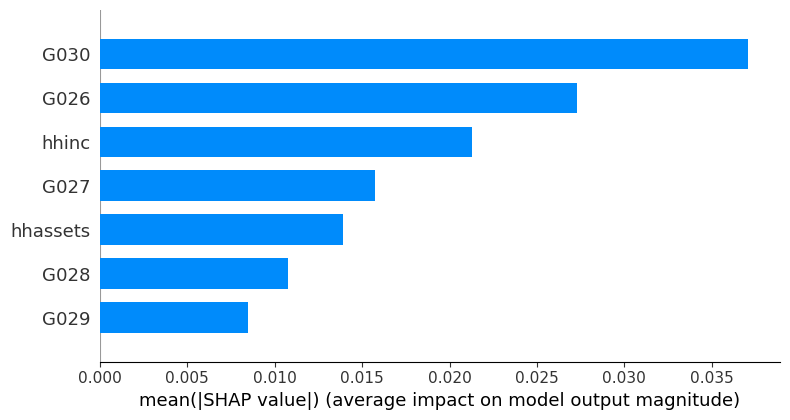

In [16]:
shap.summary_plot(rfr_shap_values, x_train_filtered_rfr, feature_names=features, plot_type="bar")


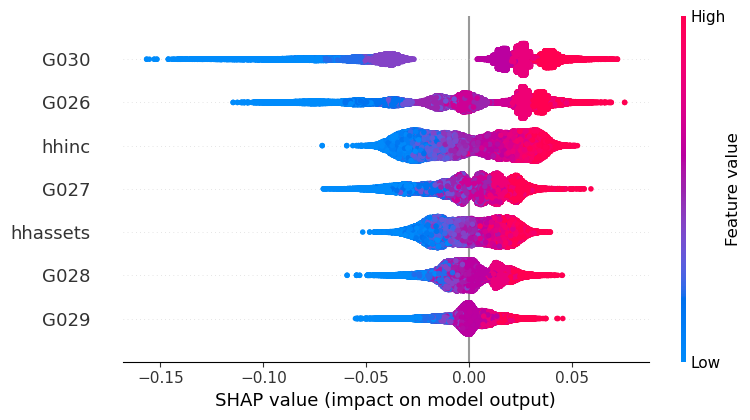

In [17]:
shap.summary_plot(rfr_shap_values, x_train_filtered_rfr, feature_names=features)


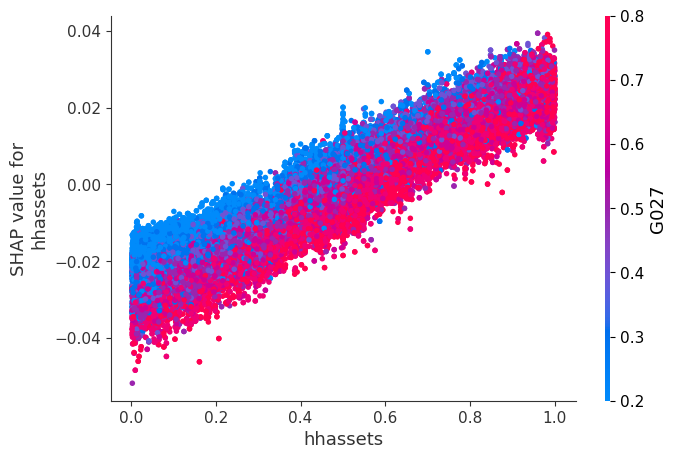

In [18]:
shap.dependence_plot(5, rfr_shap_values, x_train_filtered_rfr, feature_names=features)


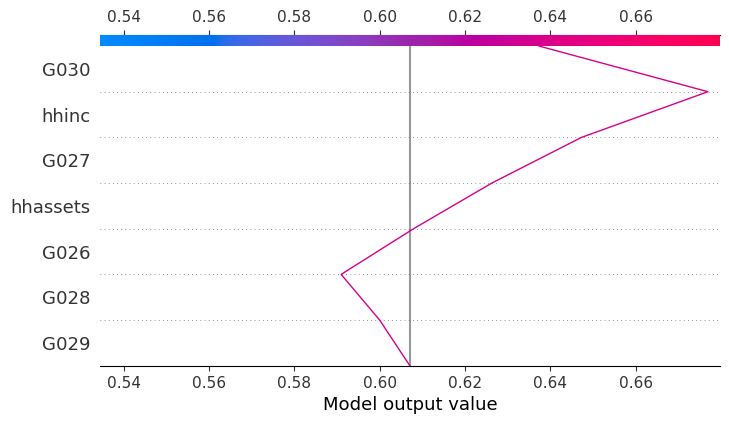

In [19]:
shap.decision_plot(rfr_explainer.expected_value[0], rfr_shap_values[0], feature_names = list(features))


In [39]:
rfr_explainer.expected_value

array([0.60707742])

### Variance Analysis

In [12]:
# Calculate residuals for Random Forest
y_pred_rfr = rfr_regressor.predict(x_train_filtered_rfr)
residuals_rfr = y_train - y_pred_rfr

In [13]:
# Calculate residuals for Linear Regression
y_pred_linear = linear_regressor.predict(x_train)
residuals_linear = y_train - y_pred_linear

In [14]:
# Prepare data for ANOVA
x_train_with_target_linear = x_train.copy()
x_train_with_target_linear['residuals_linear'] = residuals_linear
x_train_with_target_linear['score'] = y_train

# Perform ANOVA for residuals of Linear Regression model
model_linear_residuals = ols('residuals_linear ~ ' + ' + '.join(x_train.columns), data=x_train_with_target_linear).fit()
anova_linear_residuals = sm.stats.anova_lm(model_linear_residuals, typ=2)

# Display ANOVA table
anova_linear_residuals = pd.DataFrame(anova_linear_residuals).sort_values(by='F', ascending=False)
anova_linear_residuals

,sum_sq,df,F,PR(>F)
birth_interval,5.333662e-27,1.0,217957.617667,0.000000e+00
A002y,5.288798e-27,1.0,216124.282637,0.000000e+00
age_interval,4.846522e-27,1.0,198050.867389,0.000000e+00
A002_age,4.339676e-27,1.0,177338.863444,0.000000e+00
G027,2.256532e-27,1.0,92212.135808,0.000000e+00
hhinc,1.603719e-27,1.0,65535.219791,0.000000e+00
C108,3.613220e-28,1.0,14765.255513,0.000000e+00
C142,2.681334e-28,1.0,10957.146188,0.000000e+00
year,2.578470e-28,1.0,10536.797159,0.000000e+00
G028,1.907711e-28,1.0,7795.774053,0.000000e+00


In [16]:
# Prepare data for ANOVA
x_train_with_target_rfr = x_train_filtered_rfr.copy()
x_train_with_target_rfr['residuals_rfr'] = residuals_rfr
x_train_with_target_rfr['score'] = y_train

# Perform ANOVA for residuals of Linear Regression model
model_rfr_residuals = ols('residuals_rfr ~ ' + ' + '.join(x_train_filtered_rfr.columns), data=x_train_with_target_linear).fit()
anova_rfr_residuals = sm.stats.anova_lm(model_rfr_residuals, typ=2)

# Display ANOVA table
anova_rfr_residuals = pd.DataFrame(anova_rfr_residuals).sort_values(by='F', ascending=False)
anova_rfr_residuals

,sum_sq,df,F,PR(>F)
G028,0.010381,1.0,176.860418,2.628776e-40
G029,0.009514,1.0,162.083910,4.359055e-37
G030,0.001360,1.0,23.166918,1.488387e-06
hhassets,0.000276,1.0,4.702317,3.012532e-02
G027,0.000134,1.0,2.286213,1.305326e-01
hhinc,0.000008,1.0,0.140498,7.077875e-01
G026,0.000001,1.0,0.024542,8.755148e-01
Residual,4.123748,70257.0,NaN,NaN


In [17]:
anova_linear_residuals.to_csv('anova_linear.csv')
anova_rfr_residuals.to_csv('anova_rfr.csv')